In [1]:
import math
import tensorflow as tf
from tensorflow.contrib import learn
import numpy as np
import pylab as plt
import pickle
import os
import csv
import sys
import time
from datetime import timedelta
import pandas

C:\Users\lzcai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
LEARNING_RATE = 0.01
EPOCHS = 2000
BATCH_SIZE = 128
MAX_DOC_LEN = 100
CHAR_DEPTH = 256
WORD_WIDTH = 20
NUM_CLASSES = 15
DROP = True
EMBEDDING_SIZE = 50
NUM_HIDDEN = 20

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
DATA_DIR = "../data"
SAVE_DIR = "../data/PartB_Result"
RESULT_DIR = "../data/PartB_Result/1112/Q6/4-c"
TRAIN_CHAR_FILENAME = "Train_char.out"
TEST_CHAR_FILENAME = "Test_char.out"
TRAIN_WORD_FILENAME = "Train_word_raw.out"
TEST_WORD_FILENAME = "Test_word_raw.out"

In [4]:
with open(os.path.join(SAVE_DIR, TRAIN_WORD_FILENAME),"rb") as f:
    trainX, tmp_trainY = pickle.load(f)

In [5]:
with open(os.path.join(SAVE_DIR, TEST_WORD_FILENAME),"rb") as f:
    testX, tmp_testY = pickle.load(f)

In [6]:
trainY_targets = np.array(tmp_trainY).reshape(-1)
trainY = np.eye(NUM_CLASSES)[trainY_targets]

testY_targets = np.array(tmp_testY).reshape(-1)
testY = np.eye(NUM_CLASSES)[testY_targets]
# trainY = y_train
# testY = y_test

In [7]:
def rnn_model(x, n_words):

    word_vectors = tf.contrib.layers.embed_sequence(
        x, vocab_size=n_words, embed_dim=EMBEDDING_SIZE)

    word_list = tf.unstack(word_vectors, axis=1)

    cell = tf.nn.rnn_cell.GRUCell(NUM_HIDDEN)
    _, encoding = tf.nn.static_rnn(cell, word_list, dtype=tf.float32)

    logits = tf.layers.dense(encoding, NUM_CLASSES, activation=None)

    return logits, word_list

In [8]:
n_words = max([max(tmp) for tmp in trainX]+[max(tmp) for tmp in testX])

In [9]:
n_words

37361

In [10]:
def setup_cross_entropy(labels, logits):
    return tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

def setup_correct_prediction(labels, logits):
    return tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32)

In [11]:
x = tf.placeholder(tf.int64, [None, MAX_DOC_LEN])
d = tf.placeholder(tf.float32, [None, NUM_CLASSES])
y, word_list = rnn_model(x, n_words)

cross_entropy = setup_cross_entropy(labels=d, logits=y)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
gvs = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

In [12]:
correct_prediction = setup_correct_prediction(labels=d, logits=y)
accuracy = tf.reduce_mean(correct_prediction)

In [13]:
saver = tf.train.Saver()
if not os.path.exists(RESULT_DIR):
    print("Not Exist")
    os.makedirs(RESULT_DIR)

Not Exist


In [14]:
def plot_graph(EPOCHS, BATCH_SIZE, acc_record, fileName, isTrain, error = False):
    if error:  
        acc_record = [1-tmp for tmp in acc_record]
        if isTrain:
            yLabel = 'Train error'
        else:
            yLabel = 'Test error'
    else:
        if isTrain:
            yLabel = 'Train accuracy'
        else:
            yLabel = 'Test accuracy'
    plt.figure(1)
    plt.plot(range(EPOCHS), acc_record)
    plt.xlabel(str(EPOCHS) + ' iterations')
    plt.ylabel(yLabel)
    plt.ylim((0,1))
    plt.savefig(os.path.join(RESULT_DIR, fileName))
    plt.show()

In [15]:
def validation_accuracy(testX, testY):
    output_2_, accuracy_ = session.run([y, accuracy], feed_dict={x: testX, d: testY})
    print(output_2_, '\n',accuracy_)

In [16]:
train_acc_backup = []
test_acc_backup = []
time_usage_backup = []
total_time_backup = []

iter 0: Train accuracy 0.0733929 Test accuracy:  0.071428575 *
Time usage: 0:00:07
iter 50: Train accuracy 0.849464 Test accuracy:  0.5257143 *
Time usage: 0:00:18
iter 100: Train accuracy 1 Test accuracy:  0.6685714 *
Time usage: 0:00:29
iter 150: Train accuracy 1 Test accuracy:  0.6471428 
Time usage: 0:00:39
iter 200: Train accuracy 1 Test accuracy:  0.64 
Time usage: 0:00:49
iter 250: Train accuracy 1 Test accuracy:  0.6414286 
Time usage: 0:00:58
iter 300: Train accuracy 1 Test accuracy:  0.64 
Time usage: 0:01:08
iter 350: Train accuracy 1 Test accuracy:  0.6342857 
Time usage: 0:01:18
iter 400: Train accuracy 1 Test accuracy:  0.63 
Time usage: 0:01:28
iter 450: Train accuracy 1 Test accuracy:  0.62714285 
Time usage: 0:01:38
iter 500: Train accuracy 1 Test accuracy:  0.64428574 
Time usage: 0:01:48
iter 550: Train accuracy 1 Test accuracy:  0.63857144 
Time usage: 0:01:58
iter 600: Train accuracy 1 Test accuracy:  0.6357143 
Time usage: 0:02:08
iter 650: Train accuracy 1 Test a

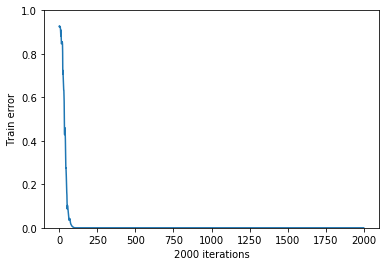

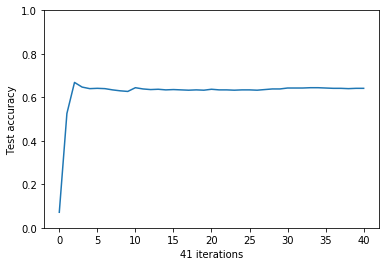

In [17]:
# print("BATCH_SIZE=", BATCH_SIZE)
total_iterations = 0
train_acc = []
start_time = time.time()
train_acc_record = []
test_acc_record = []
epoch_time_record = []

best_test_acc = 0.0
last_improvement = 0
improved_str = ""
test_count = 0
train_count = 0
mul = int(len(trainX)/BATCH_SIZE)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(EPOCHS):
        epoch_start_time = time.time()
        
#         for j in range(len(x_allBatch)):
#         for j in range(mul):
#             feed_dict_train = {x: x_allBatch[j], d: y_allBatch[j]}
#             x_batch, d_batch = next_batch(BATCH_SIZE, trainX, trainY)
        feed_dict_train = {x: trainX, d: trainY}
        sess.run(train_op, feed_dict=feed_dict_train)
        train_acc_record.append(accuracy.eval(feed_dict=feed_dict_train))
        train_count += 1
            
        epoch_end_time = time.time()
        epoch_time_diff = epoch_end_time-epoch_start_time
        epoch_time_record.append(epoch_time_diff)

        if (i % 50 == 0) or (i == (EPOCHS - 1)):
            test_count += 1
            test_accuracy = sess.run(accuracy, feed_dict={x: testX, d: testY})
            test_acc_record.append(test_accuracy)
            if DROP:
                if test_accuracy > best_test_acc:
                    best_test_acc = test_accuracy
                    last_improvement = i
                    saver.save(sess=sess, save_path=RESULT_DIR)
                    improved_str = "*"
                else:
                    improved_str = ''
            else:
                saver.save(sess=sess, save_path=RESULT_DIR)

            print('iter %d: Train accuracy %g'%(i, train_acc_record[i]), 'Test accuracy: ',test_accuracy, improved_str)
            print("Time usage: " + str(timedelta(seconds=int(round(time.time()-start_time)))))


# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

train_graphName = "PartB-Q6-4-Train"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png"
test_graphName = "PartB-Q6-4-Test"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png"
plot_graph(train_count, BATCH_SIZE, train_acc_record,train_graphName, isTrain = True, error=True)
plot_graph(test_count, BATCH_SIZE, test_acc_record, test_graphName, isTrain = False)


train_acc_backup.append(train_acc_record)
test_acc_backup.append(test_acc_record)
time_usage_backup.append(epoch_time_record)
total_time_backup.append(time_dif)

#=========== Save all the data for EACH TRAINING Has Done ============#
fileNameTail = str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"

train_acc_filename = "PartB-Q6-4-Train_Acc-"+fileNameTail
with open(os.path.join(RESULT_DIR, train_acc_filename), 'wb') as fp:
    pickle.dump(train_acc_backup, fp)

test_acc_filename = "PartB-Q6-4-Test_Acc-"+fileNameTail
with open(os.path.join(RESULT_DIR, test_acc_filename), 'wb') as fp:
    pickle.dump(test_acc_backup, fp)

time_usage_filename = "PartB-Q6-4-Time_Usage-"+fileNameTail
with open(os.path.join(RESULT_DIR, time_usage_filename), 'wb') as fp:
    pickle.dump(time_usage_backup, fp)

time_usage_filename = "PartB-Q6-4-Time_Usage-"+fileNameTail
with open(os.path.join(RESULT_DIR, time_usage_filename), 'wb') as fp:
    pickle.dump(time_usage_backup, fp)        
